In [6]:
!pip install pandas --user
!pip install seaborn --user
!pip install matplotlib --user
!pip install imblearn --user
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
import os
target_loc = "/content/drive/MyDrive/CSE802/rows.csv"
# if not os.path.exists("/VL/space/kamalida/files/rows.csv"):
if not os.path.exists(target_loc):
  if os.path.exists(target_loc):
    !cp /content/drive/MyDrive/CSE802/rows.csv /content/rows.csv
  else:
    !wget "https://data.cityofchicago.org/api/views/ijzp-q8t2/rows.csv?accessType=DOWNLOAD&bom=true&query=select+*" -O "rows.csv"

In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from typing import *
import numpy as np
import sklearn


Load dataset to pandas DataFrame


In [10]:
crime_data_main = pd.read_csv(target_loc)

Looking at the number of rows in the data

In [11]:
len(crime_data_main)

7786686

In [12]:
crime_data_main.head()

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,Longitude,Location,Historical Wards 2003-2015,Zip Codes,Community Areas,Census Tracts,Wards,Boundaries - ZIP Codes,Police Districts,Police Beats
0,10224738,HY411648,09/05/2015 01:30:00 PM,043XX S WOOD ST,0486,BATTERY,DOMESTIC BATTERY SIMPLE,RESIDENCE,False,True,...,-87.670000,"(41.815117282, -87.669999562)",29.0,14924.0,59.0,706.0,3.0,37.0,23.0,108.0
1,10224739,HY411615,09/04/2015 11:30:00 AM,008XX N CENTRAL AVE,0870,THEFT,POCKET-PICKING,CTA BUS,False,False,...,-87.765400,"(41.895080471, -87.765400451)",4.0,4299.0,26.0,562.0,45.0,5.0,25.0,67.0
2,11646166,JC213529,09/01/2018 12:01:00 AM,082XX S INGLESIDE AVE,0810,THEFT,OVER $500,RESIDENCE,False,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10224740,HY411595,09/05/2015 12:45:00 PM,035XX W BARRY AVE,2023,NARCOTICS,POSS: HEROIN(BRN/TAN),SIDEWALK,True,False,...,-87.716650,"(41.937405765, -87.716649687)",15.0,21538.0,22.0,216.0,12.0,39.0,7.0,168.0
4,10224741,HY411610,09/05/2015 01:00:00 PM,0000X N LARAMIE AVE,0560,ASSAULT,SIMPLE,APARTMENT,False,True,...,-87.755121,"(41.881903443, -87.755121152)",11.0,22216.0,26.0,696.0,23.0,32.0,25.0,81.0


In [13]:
crime_data = crime_data_main ## This cell is used for debugging purposes.

## Data Cleaning

### Removing Duplicate or Unrelated Feature

In [14]:
unrealted_featurse = ['ID','Case Number','IUCR', 'Arrest','Longitude','Domestic','Beat','FBI Code','Updated On','Latitude','Historical Wards 2003-2015', 'Boundaries - ZIP Codes','Location']
related_feature_before_the_dispatch = set(crime_data.columns) - set(unrealted_featurse)


In [15]:
crime_data = crime_data[related_feature_before_the_dispatch]
list(crime_data.columns),len(list(crime_data.columns))

<ipython-input-15-0073c83be788>:1: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  crime_data = crime_data[related_feature_before_the_dispatch]


(['X Coordinate',
  'Date',
  'Year',
  'Police Districts',
  'Ward',
  'Primary Type',
  'Community Area',
  'Community Areas',
  'Y Coordinate',
  'Zip Codes',
  'Census Tracts',
  'Police Beats',
  'Location Description',
  'Description',
  'Block',
  'District',
  'Wards'],
 17)

### Removing Non-criminal classes

In [16]:
useless_types = ['NON-CRIMINAL (SUBJECT SPECIFIED)','NON-CRIMINAL','NON - CRIMINAL','CONCEALED CARRY LICENSE VIOLATION','DOMESTIC VIOLENCE','PUBLIC INDECENCY','OBSCENITY','RITUALISM']
crime_data = crime_data[~crime_data['Primary Type'].isin(useless_types)]

In [17]:
### Merging Similar Classes
def merge_classes(x):
    if x in ['OTHER NARCOTIC VIOLATION','NARCOTICS']:
        return 'NARCOTICS'
    elif x in ['PROSTITUTION','CRIM SEXUAL ASSAULT','SEX OFFENSE']:
        return 'SEX OFFENSE'
    elif x in ['RITUALISM','LIQUOR LAW VIOLATION','GAMBLING']:
        return 'GAMBLING'
    elif x in ['CRIMINAL TRESPASS','ROBBERY']:
        return 'ROBBERY or TRESPASS'
    elif x in ['INTERFERENCE WITH PUBLIC OFFICER','PUBLIC PEACE VIOLATION']:
        return 'PUBLIC PEACE VIOLATION'
    return x
crime_data['Primary Type'] = crime_data['Primary Type'].map(merge_classes)

### Removing N/A rows

In [18]:
crime_data = crime_data.dropna()

In [19]:
len(crime_data)

7058771

## Feature Engineering
### Time data features

In [20]:
from datetime import datetime
from dateutil.parser import parse
crime_data["Date"] = pd.to_datetime(crime_data["Date"],format='%m/%d/%Y %I:%M:%S %p')

In [21]:
def convert_time_to_time_of_day(date:datetime):
  if 0 <= date.hour  < 6:
    return "Midnight to Morning"
  elif 6 <= date.hour  < 12:
    return "Morning to Noon"
  elif 12 <= date.hour  < 18:
    return "Noon to Afternoon"
  elif 18 <= date.hour  < 24:
    return "Afternoon to Midnight"

crime_data["Weekday"] = crime_data["Date"].map(lambda x:x.weekday())
crime_data["Time of Day"] = crime_data["Date"].map(convert_time_to_time_of_day)
crime_data["Month"] = crime_data["Date"].map(lambda x:x.month)
crime_data = crime_data.drop("Date",axis=1)

## Analysis

Text(0, 0.5, 'Crime Reported')

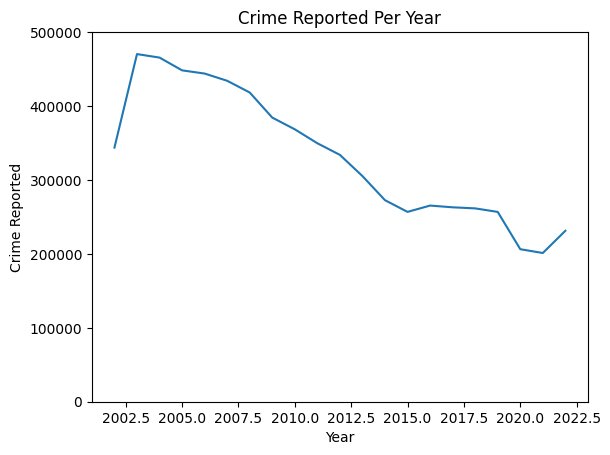

In [22]:
data = crime_data["Year"][crime_data["Year"] < 2023]
data = data[data>2001]
values, counts = np.unique(data, return_counts=True)
plt.plot(values.astype(np.int32), counts)
plt.ylim([0, 500_000])
plt.title("Crime Reported Per Year")
plt.xlabel("Year")
plt.ylabel("Crime Reported")

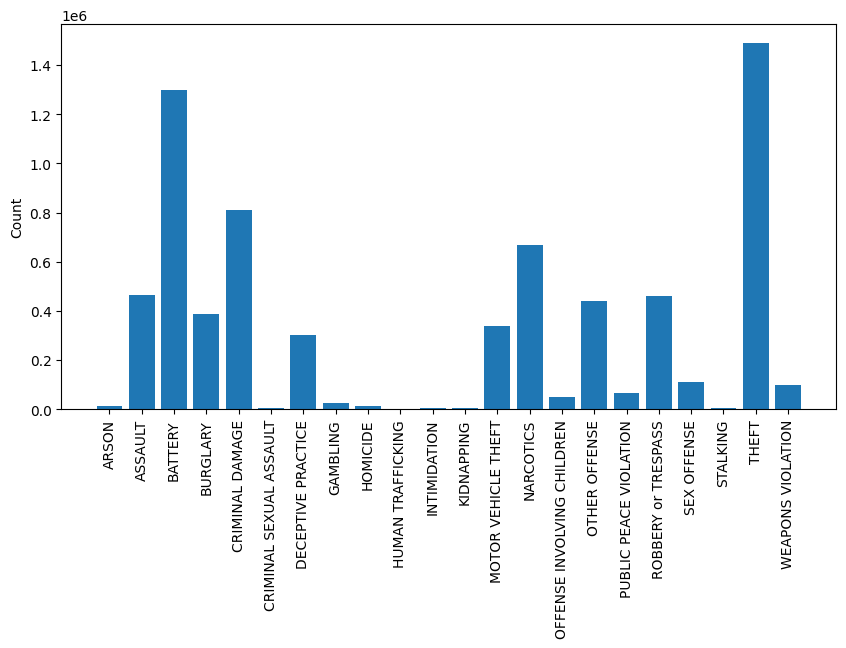

In [23]:
values, counts = np.unique(crime_data["Primary Type"], return_counts=True)
fig, ax = plt.subplots(figsize=(10,5))
plt.bar(x=values,height=counts)
plt.ylabel("Count")
_ = plt.xticks(rotation='vertical')

<Axes: >

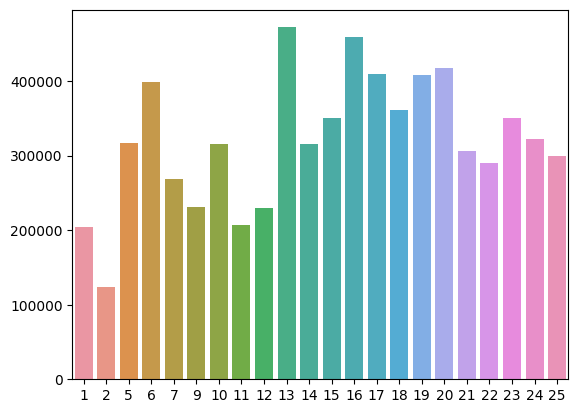

In [24]:
values, counts = np.unique(crime_data["Police Districts"], return_counts=True)
sns.barplot(x=values.astype(np.int32),y=counts)

In [25]:
def vertical_histplot(*args,**kwargs):
  sns.histplot(*args,**kwargs)
  plt.xticks(rotation='vertical')

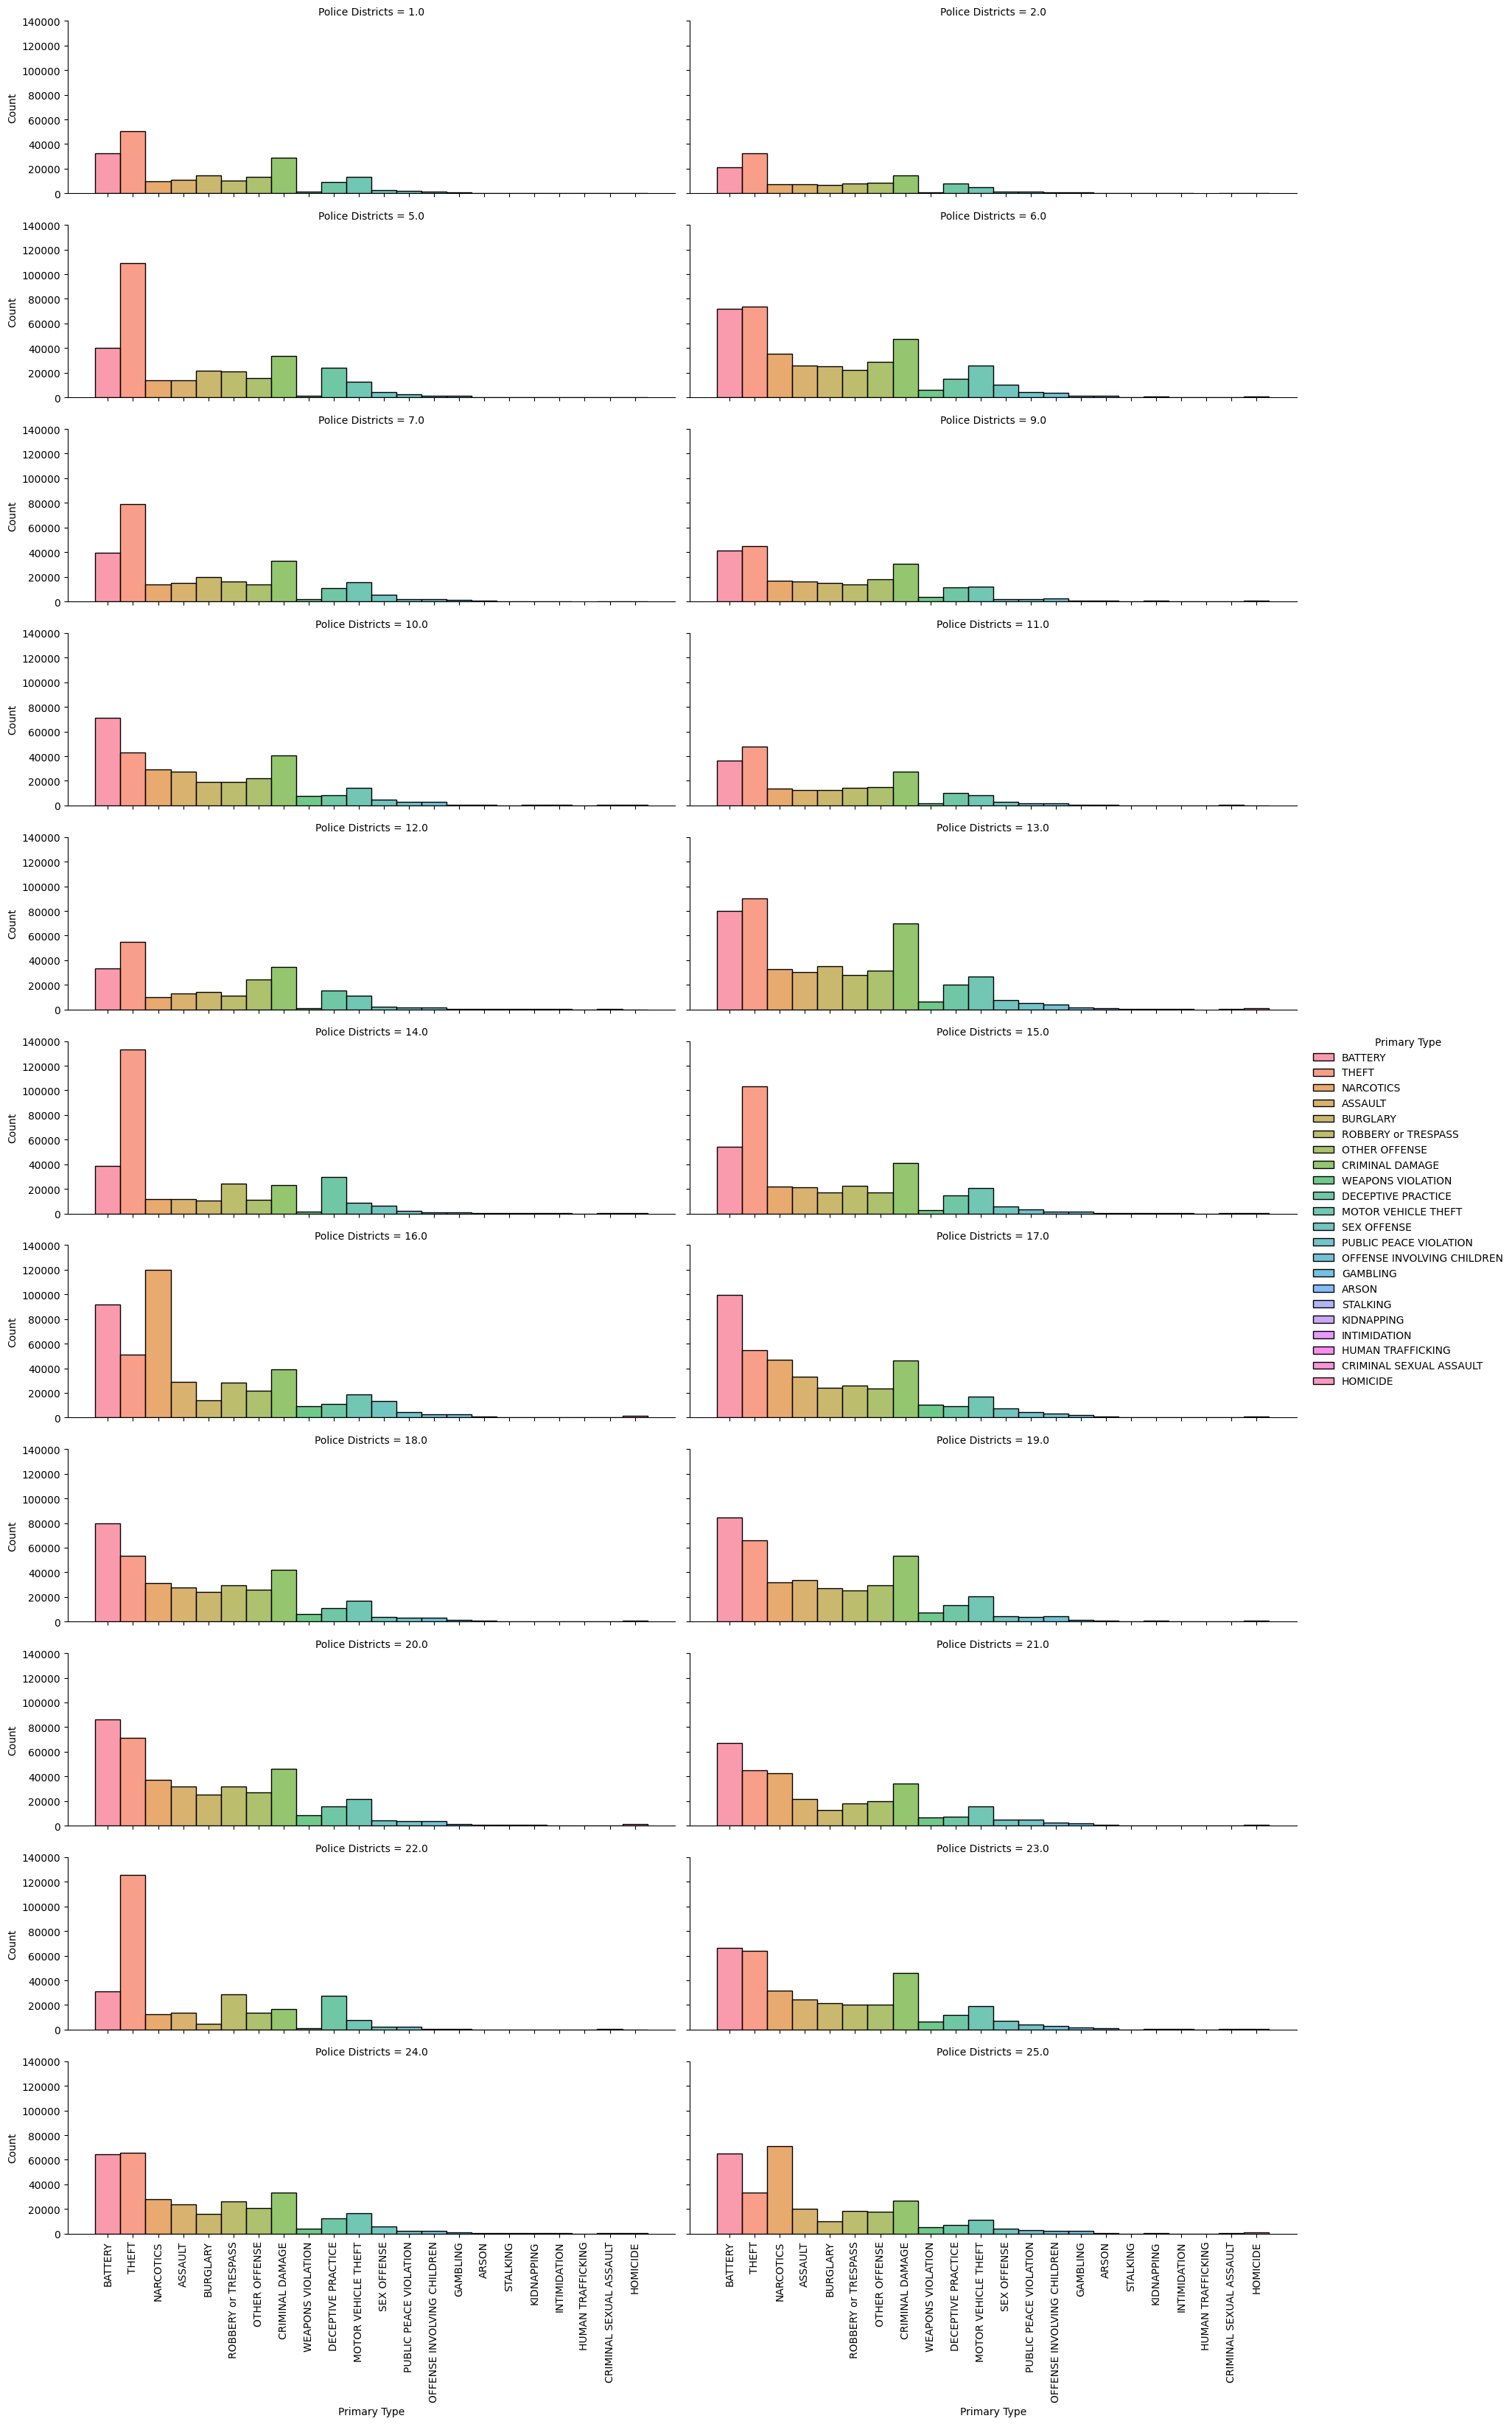

In [26]:
g = sns.FacetGrid(crime_data, col="Police Districts", hue="Primary Type",margin_titles=True,col_wrap=2,aspect=3)
g.map(vertical_histplot, "Primary Type", alpha=.7,)
g.add_legend()

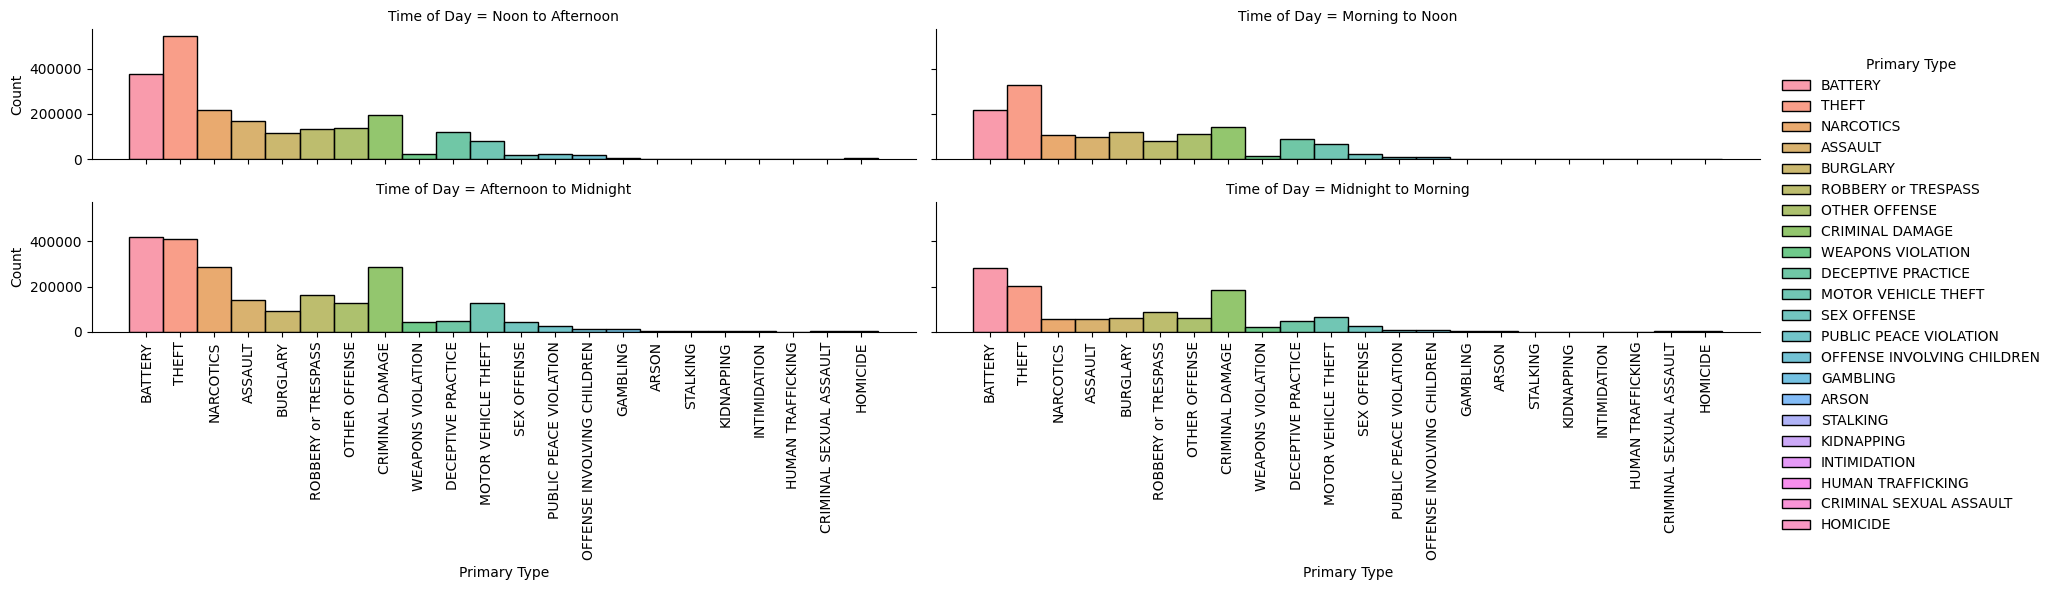

In [27]:
g = sns.FacetGrid(crime_data, col="Time of Day", hue="Primary Type",margin_titles=True,col_wrap=2,aspect=3)
g.map(vertical_histplot, "Primary Type", alpha=.7,)
g.add_legend()

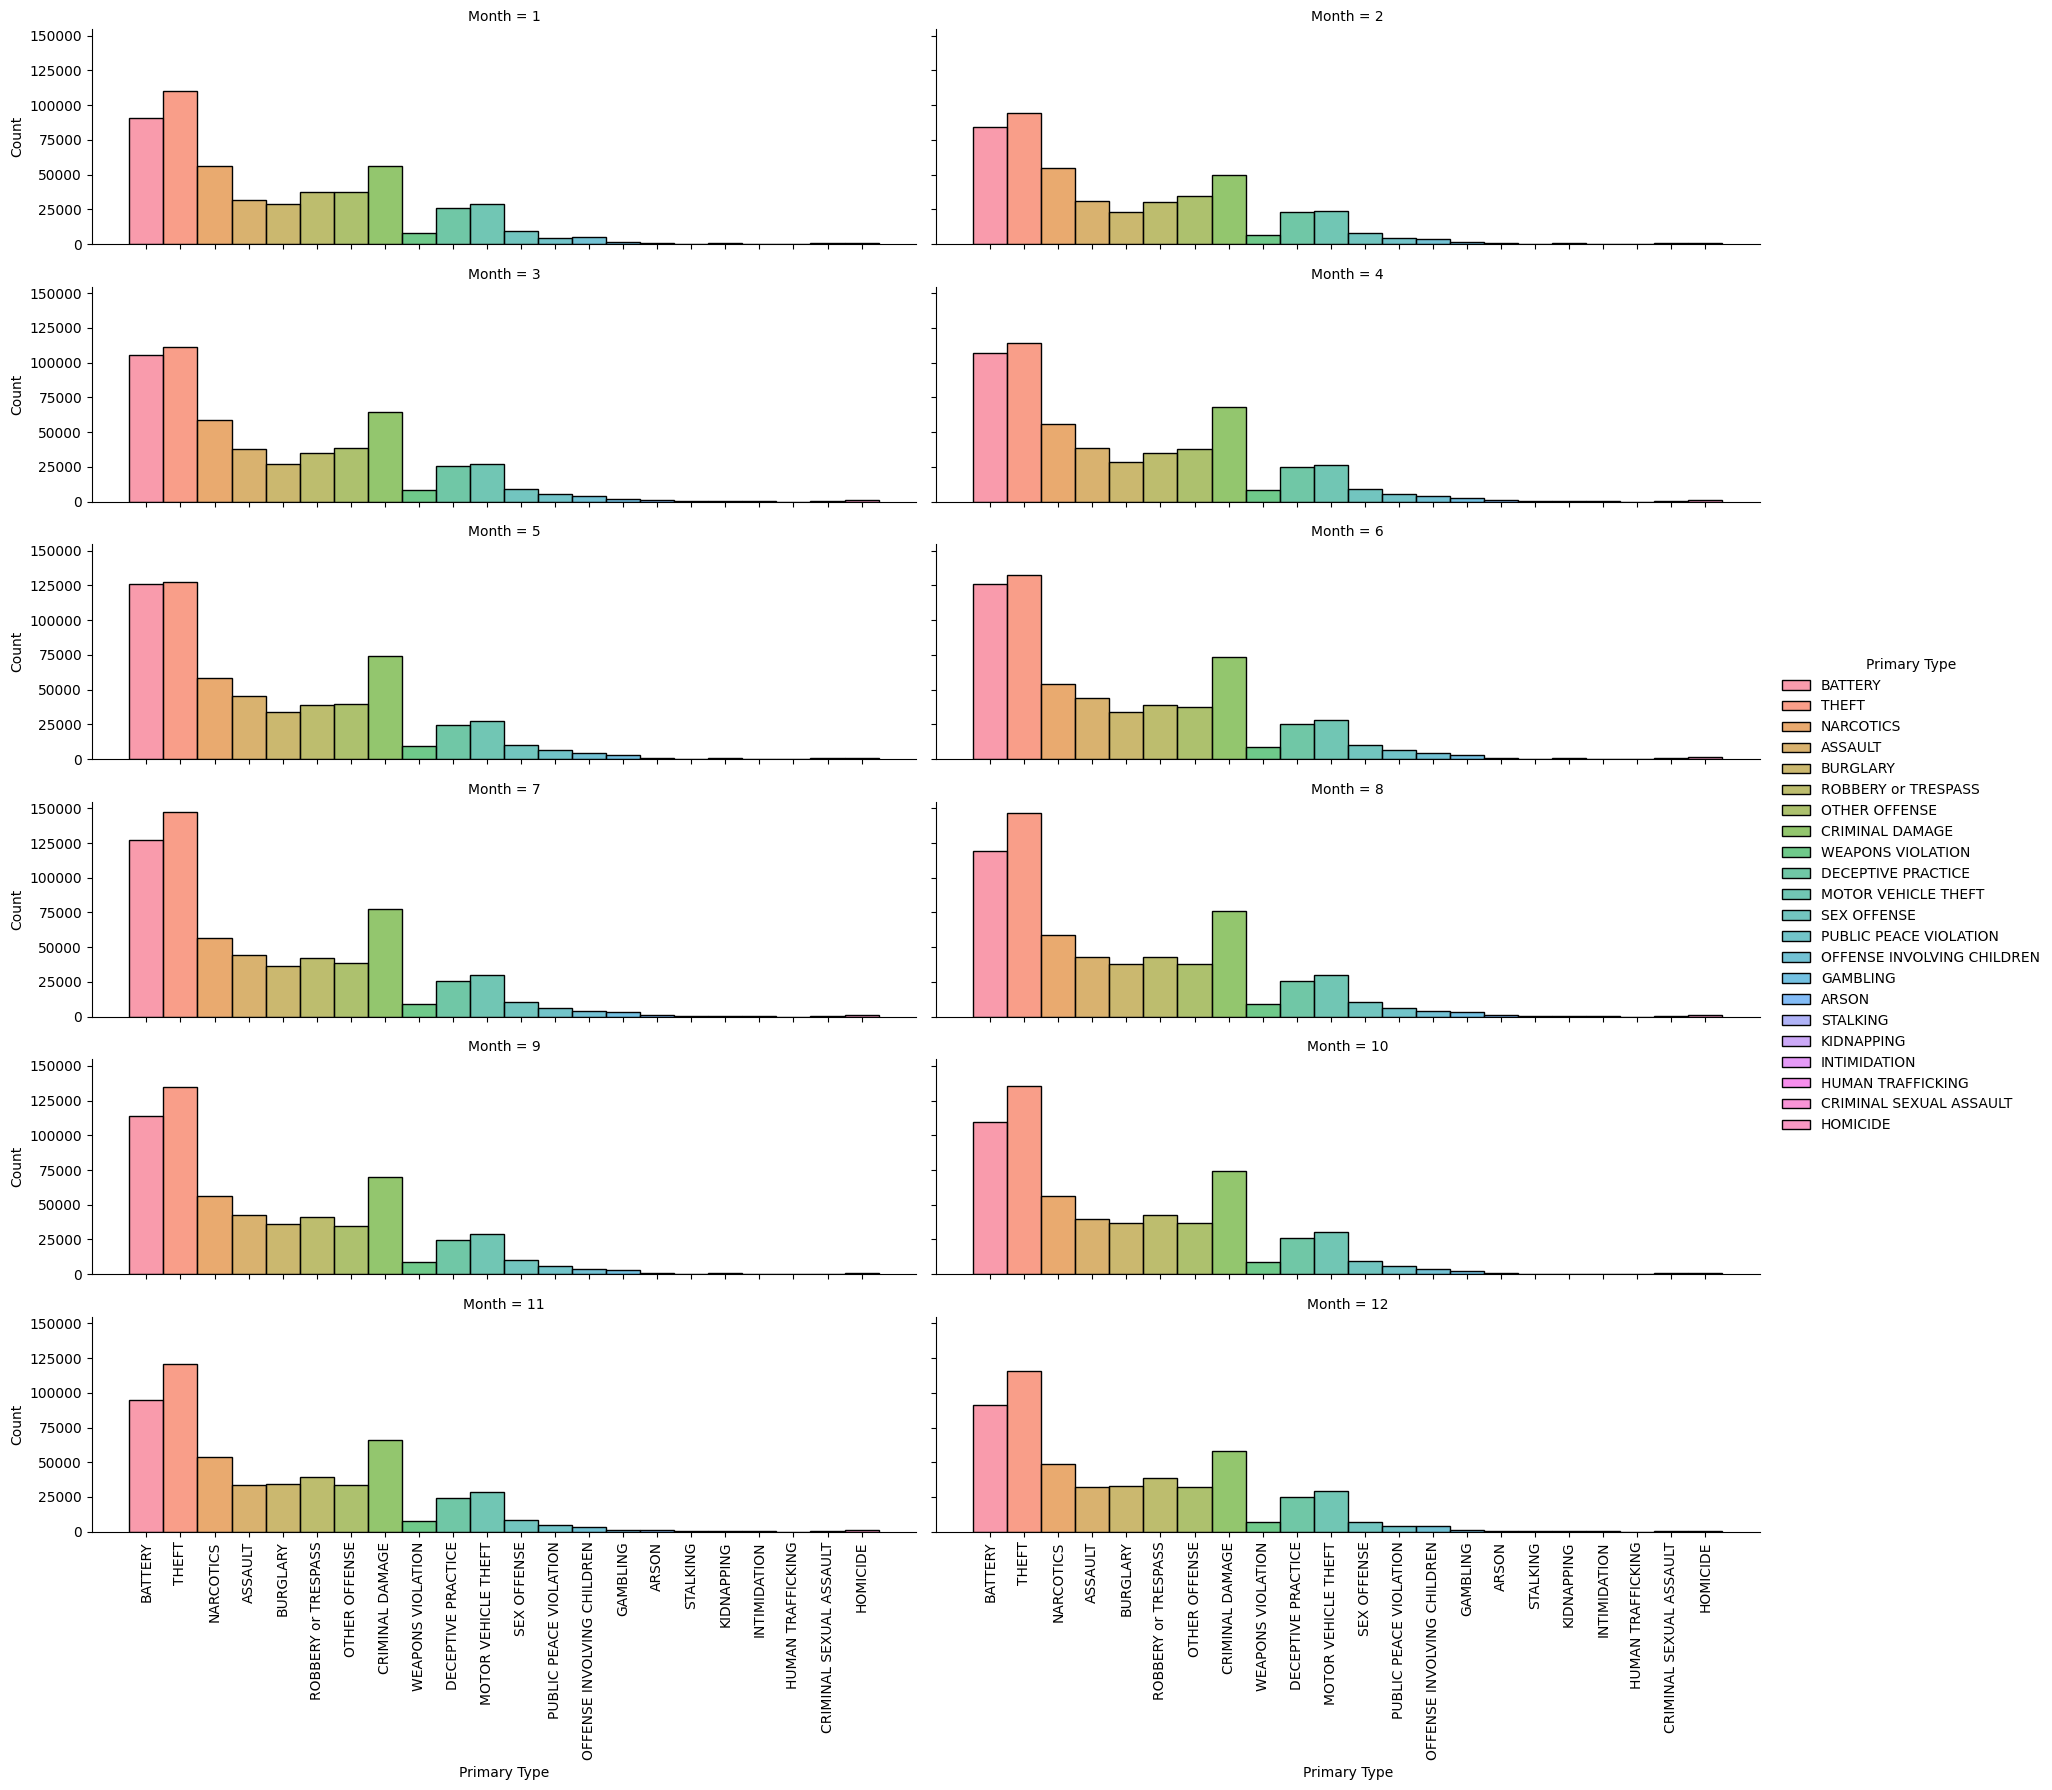

In [28]:
g = sns.FacetGrid(crime_data, col="Month", hue="Primary Type",margin_titles=True,col_wrap=2,aspect=3)
g.map(vertical_histplot, "Primary Type", alpha=.7,)
g.add_legend()

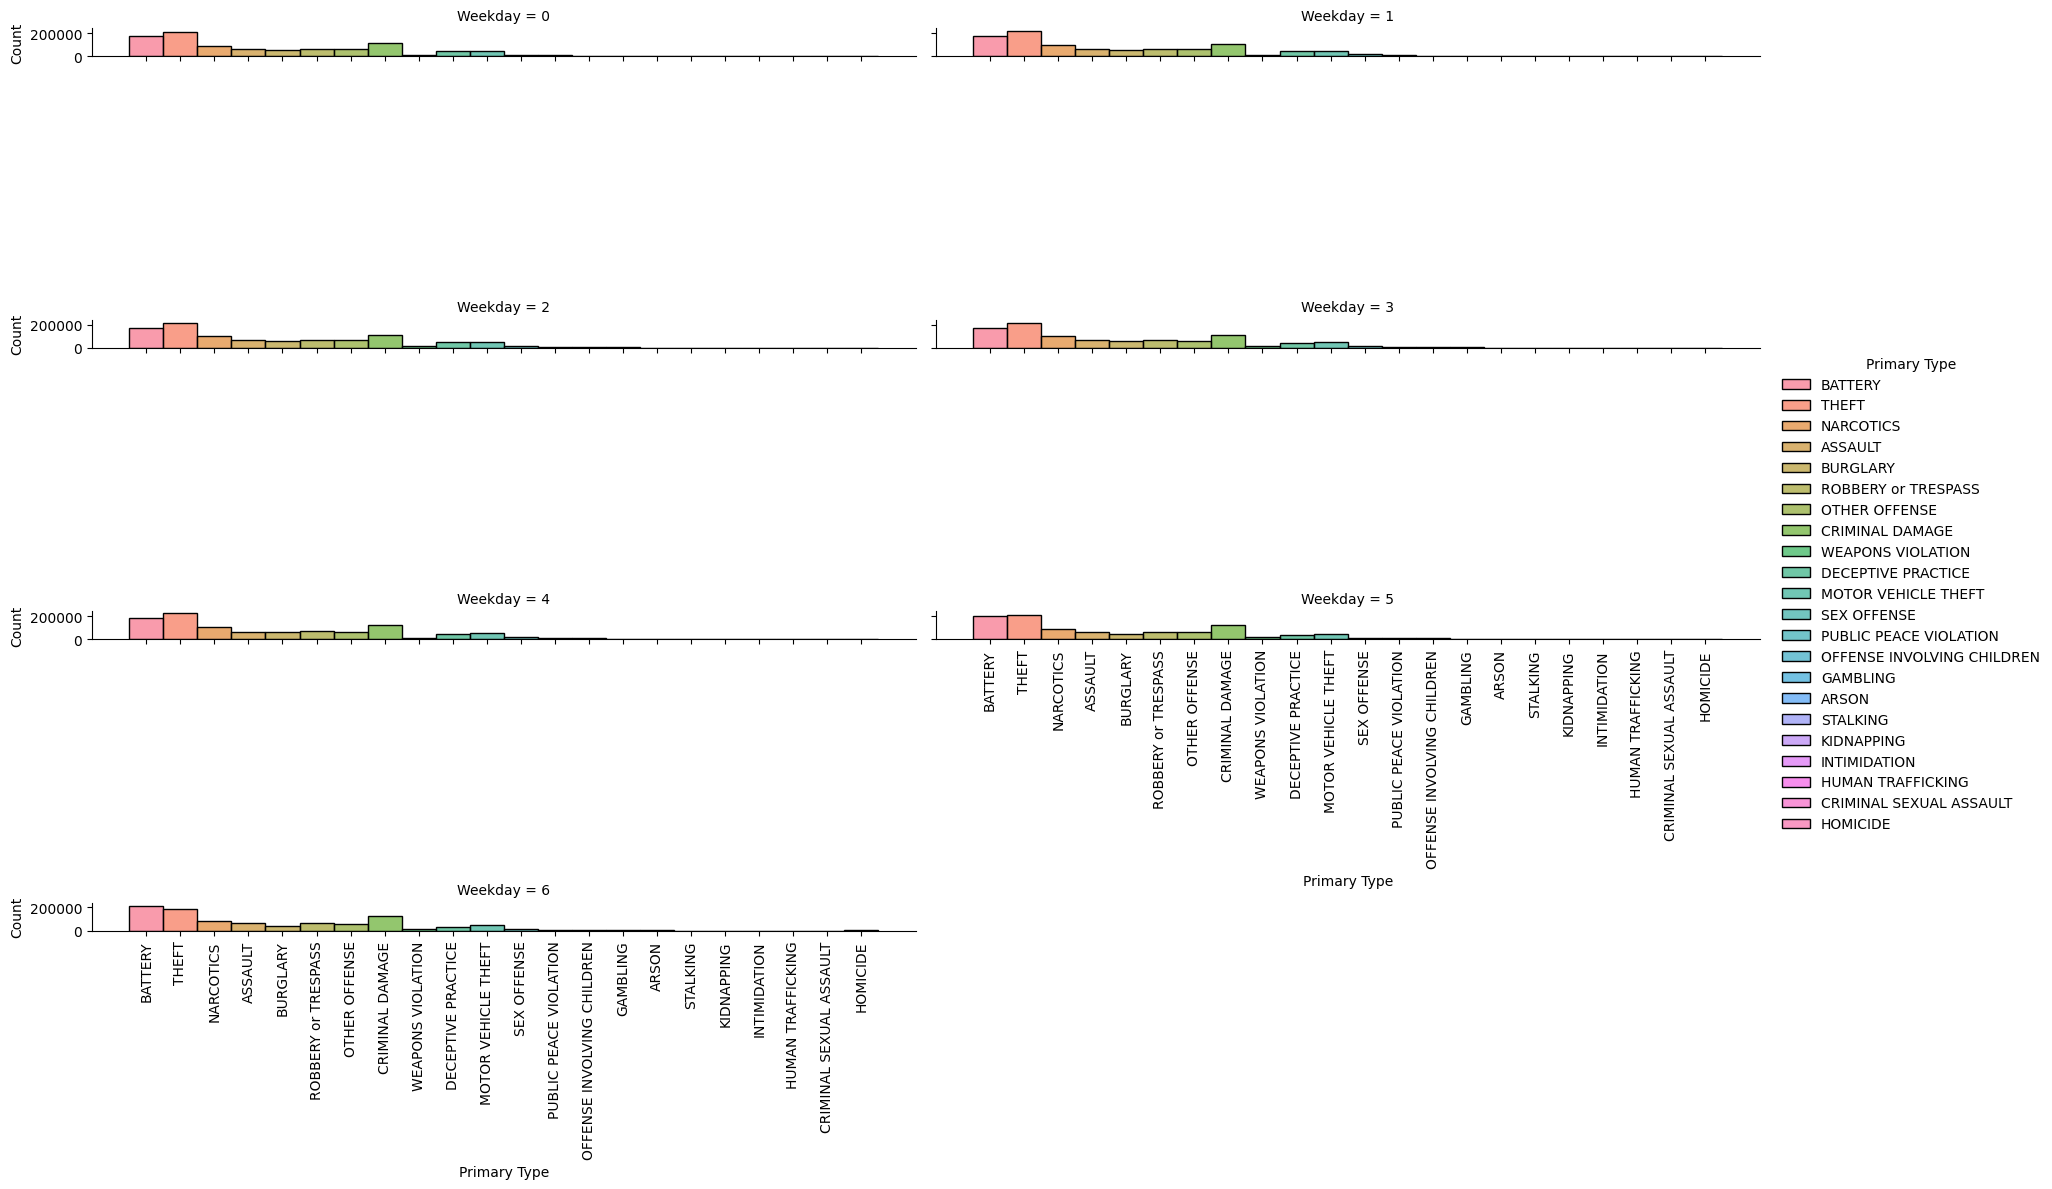

In [29]:
g = sns.FacetGrid(crime_data, col="Weekday", hue="Primary Type",margin_titles=True,col_wrap=2,aspect=3)
g.map(vertical_histplot, "Primary Type", alpha=.7,)
g.add_legend()

### Convrting String Data to Integer Labels

In [30]:
def convert_textual_series_to_indexes(series:pd.Series)->Tuple[pd.Series,dict]:
  items_list = list(series.unique())
  items_index = {crime:index for index,crime in enumerate(items_list)}
  new_series = series.apply(lambda x:items_index[x])
  return new_series, items_list

def update_df_textual_series_to_indexes(df:pd.DataFrame,col_name:str)->dict:
  df[col_name], items_list =  convert_textual_series_to_indexes(df[col_name])
  return items_list

In [31]:
primary_crime_type_to_index = update_df_textual_series_to_indexes(crime_data,"Primary Type")
location_description_to_index = update_df_textual_series_to_indexes(crime_data,"Location Description")
time_of_day_to_index = update_df_textual_series_to_indexes(crime_data,"Time of Day")
time_of_day_to_index = update_df_textual_series_to_indexes(crime_data,"Description")
time_of_day_to_index = update_df_textual_series_to_indexes(crime_data,"Block")

In [32]:
data_for_classifier = crime_data[crime_data["Year"] == 2022]
data_for_classifier.head()

,X Coordinate,Year,Police Districts,Ward,Primary Type,Community Area,Community Areas,Y Coordinate,Zip Codes,Census Tracts,Police Beats,Location Description,Description,Block,District,Wards,Weekday,Time of Day,Month
254410,1180381.0,2022,24.0,3.0,9,38.0,4.0,1874867.0,4301.0,161.0,114.0,0,31,13356,2.0,9.0,2,0,3
991297,1148576.0,2022,21.0,24.0,21,29.0,30.0,1894174.0,21569.0,761.0,155.0,6,369,5290,10.0,14.0,2,1,9
1047294,1193919.0,2022,18.0,7.0,7,43.0,39.0,1856789.0,22538.0,245.0,213.0,3,13,361,3.0,37.0,5,3,1
1047295,1177024.0,2022,17.0,6.0,7,69.0,67.0,1859232.0,21559.0,513.0,210.0,11,13,3447,7.0,32.0,5,3,1
1047301,1144522.0,2022,25.0,24.0,0,25.0,26.0,1895783.0,22216.0,61.0,137.0,6,3,14722,11.0,7.0,5,3,1


## Feature Selection

In [33]:
y_column = "Primary Type"
x_columns = list(set(data_for_classifier.columns)-set([y_column]))

### Correlation Based Feature Selection

In [34]:
correlations = data_for_classifier[x_columns].corr()
upper = correlations.where(np.triu(np.ones(correlations.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
print("Dropped:", to_drop)
x_columns = list(set(x_columns)-set(to_drop))

Dropped: []


<ipython-input-34-9d38b1909060>:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = correlations.where(np.triu(np.ones(correlations.shape), k=1).astype(np.bool))


In [35]:
correlations = data_for_classifier[x_columns].corrwith(data_for_classifier[y_column]).map(abs)
total_on_that_point = 0
temp_x_columns = []
for feature,correlation in sorted(list(zip(x_columns,correlations)),key=lambda x:-x[1]):
    total_on_that_point += correlation
    if (total_on_that_point /sum(correlations)) > 0.95:
      break
    temp_x_columns.append(feature)
print("Removed Features", set(x_columns) - set(temp_x_columns))
x_columns = temp_x_columns



Removed Features set()


In [36]:
len(data_for_classifier),len(x_columns)

(231252, 18)

In [37]:
X, Y = data_for_classifier[x_columns].to_numpy(), data_for_classifier[y_column].to_numpy()
X, Y = sklearn.utils.shuffle(X,Y,random_state=333)

### Sequential Backward Feature Selector

In [38]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC

In [ ]:
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import make_scorer, f1_score
import random

sfs = SequentialFeatureSelector(RandomForestClassifier(n_jobs=-1), n_jobs=-1,scoring=make_scorer(f1_score,average='macro'),direction='backward')
sfs.fit(X, Y)

selected_features_bool = sfs.get_support()

temp_x_columns = list(filter(lambda x:x,[feature  if selected_features_bool[index] else None for index,feature in enumerate(x_columns)]))
print("Removed Features", set(x_columns) - set(temp_x_columns))
x_columns = temp_x_columns
### if above is commented for debugging purposes
# x_columns = ['Year',
#  'Description',
#  'Y Coordinate',
#  'Block',
#  'Ward',
#  'Location Description',
#  'Census Tracts',
#  'X Coordinate']

/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_sequential.py:211: FutureWarning: Leaving `n_features_to_select` to None is deprecated in 1.0 and will become 'auto' in 1.3. To keep the same behaviour as with None (i.e. select half of the features) and avoid this warning, you should manually set `n_features_to_select='auto'` and set tol=None when creating an instance.
  warnings.warn(


In [ ]:
x_columns

In [ ]:
X,Y = data_for_classifier[x_columns].to_numpy(), data_for_classifier[y_column].to_numpy()
X, Y = sklearn.utils.shuffle(X,Y,random_state=333)

## Classifier Training

In [ ]:
from sklearn.model_selection import KFold
from imblearn.over_sampling import RandomOverSampler

from sklearn.metrics import f1_score
from tqdm import tqdm


def k_fold_training(clf,X,Y,k=5,over_sampling=False):
    kf = KFold(n_splits=k)
    scores = []
    clf = make_pipeline(StandardScaler(),clf)
    for fold, (train_index, test_index) in tqdm(enumerate(kf.split(X), 1),total=k):
        X_train = X[train_index]
        Y_train = Y[train_index]  # Based on your code, you might need a ravel call here, but I would look into how you're generating your y
        X_test = X[test_index]
        Y_test = Y[test_index]  # See comment on ravel and  y_train
        if over_sampling:
            sm = RandomOverSampler(random_state=33)
            X_train, Y_train = sm.fit_resample(X_train, Y_train)
        clf.fit(X_train, Y_train)
        Y_pred = clf.predict(X_test)
        f1_score_value = f1_score(Y_test, Y_pred,average='macro')
        print(f1_score_value)
        scores.append(f1_score_value)
    mean,variance = np.mean(scores),np.var(scores)
    return mean,variance


In [ ]:
clf_dtree = DecisionTreeClassifier(random_state=0)
mean,variance = k_fold_training(clf_dtree, X, Y,k=5)
print("mean:",mean, "variance",variance)

In [ ]:
clf_rf_tree = RandomForestClassifier(n_jobs=-1)
mean,variance = k_fold_training(clf_rf_tree, X, Y,k=5)
print("mean:",mean, "variance",variance)

In [ ]:
x_train, x_test, y_train, y_test  = train_test_split(X,Y,train_size=int(len(X)*.8),random_state=3)

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
clf_rf_tree = DecisionTreeClassifier(random_state=0)
clf_rf_tree = make_pipeline(StandardScaler(),clf_rf_tree)
clf_rf_tree.fit(x_train, y_train)
y_pred = clf_rf_tree.predict(x_test)
conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots(figsize=(8,6), dpi=100)

display = ConfusionMatrixDisplay(conf_matrix, display_labels=primary_crime_type_to_index)
plt.xticks(rotation='vertical')

display.plot(ax=ax,xticks_rotation='vertical',include_values=False);

In [ ]:
from sklearn.metrics import accuracy_score

f1_scores = []
accuracies = []
k_values = range(1,30,3)
for n in tqdm(k_values):
    clf_knn = KNeighborsClassifier(n_neighbors=n,n_jobs=-1)
    clf_knn = make_pipeline(StandardScaler(),clf_knn)
    clf_knn.fit(x_train, y_train)
    y_pred = clf_knn.predict(x_test)
    f1 = f1_score(y_test, y_pred,average='macro')
    acc = accuracy_score(y_test, y_pred)
    f1_scores.append(f1)
    accuracies.append(acc)

In [ ]:
accuracies_best_n = sorted(zip(k_values,accuracies),key=lambda x:-x[1])[0]
print("accuracies_best_n",accuracies_best_n)
f1_scores_best_n = sorted(zip(k_values,f1_scores),key=lambda x:-x[1])[0]
print("f1_scores_best_n", f1_scores_best_n)

In [ ]:
plt.plot(k_values,accuracies,label="acc")
plt.plot(k_values,f1_scores,label="f1")
plt.title("Choosing Best K")
plt.legend()
plt.xlabel("N value")
plt.ylabel("Macro F1")

In [ ]:
clf_dtree = DecisionTreeClassifier(random_state=0)
mean,variance = k_fold_training(clf_dtree, X, Y,k=5,over_sampling=True)
print("with over sampling","mean:",mean, "variance",variance)

In [ ]:
clf_rf_tree = RandomForestClassifier(random_state=0,n_jobs=-1)
mean,variance = k_fold_training(clf_rf_tree, X, Y,k=5,over_sampling=True)
print("with over sampling","mean:",mean, "variance",variance)

In [ ]:
from sklearn.metrics import accuracy_score

f1_scores = []
accuracies = []
k_values = range(1,30,3)
for n in k_values:
    clf_knn = KNeighborsClassifier(n_neighbors=n,n_jobs=-1)
    mean,variance = k_fold_training(clf_knn, X, Y,k=5,over_sampling=True)
    print(n,"==>","with over sampling","mean:",mean, "variance",variance)

In [ ]:
from sklearn.metrics import accuracy_score

clf_knn = KNeighborsClassifier(n_neighbors=1,n_jobs=-1)
mean,variance = k_fold_training(clf_knn, X, Y,k=5,over_sampling=True)
print("with over sampling","mean:",mean, "variance",variance)

Model Analysis